In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import group_data as gd

In [3]:
gd.swarms.keys()

['GMR31E10_GFP',
 'GMR22H05_GFP',
 'GMR10A12',
 'GMR31E10',
 'GMR75B06',
 'GMR22H05',
 'GMR74F03',
 'GMR29E05_GFP',
 'GMR39E01',
 'GMR29E05']

In [90]:
import muscle_model as mm
reload(mm)
confocal_model = mm.GeometricModel(filepath = 'model_data.cpkl')
confocal_view = mm.ModelViewMPL(confocal_model)

def warp_fly_image(fly,img,s = 1):
    import cv2
    import cPickle
    pkname = fly.fly_path + '/basis_fits.cpkl'
    fly_frame = mm.Frame();fly_frame.load(pkname)
    A = confocal_model.frame.get_transform(fly_frame)
    Ap = dot([[s,0.0,0],[0,s,0],[0,0,1]],A)
    output_shape = (np.array([1024,1024])*s).astype(int) #confocal shape scale
    output_shape = (output_shape[0],output_shape[1])
    X_warped = cv2.warpAffine(img.T,Ap[:-1,:],output_shape)
    return X_warped

def get_swarm_imgs(swarm):
    swarm_imgs = {'csd_mag':list(),
                'csd_phase':list(),
                'df_f_psd':list(),
                'df_f_wing_coherence':list()}

    for fly in swarm.flies:
        try:
            spectral_data = fly.get_pkl_data('spectral_data.cpkl')
            bandwidth = 1
            freqs = spectral_data['spectral_frequencies'][:,0,0]
            freq_res = freqs[1] - freqs[0]
            num_freqs = np.shape(freqs)[0]
            idx_interval = np.floor(bandwidth/freq_res)
            idx_intervals = np.arange(1,num_freqs,idx_interval).astype(int)
            idx_bands = [(x,y) for x,y in zip(idx_intervals[:-1],idx_intervals[1:])]
            bands = [(freqs[x],freqs[y]) for x,y in idx_bands]
            
            data = np.angle(spectral_data['df_f_wing_csd'])
            data = (data>0)*(-2*pi+data) + (data<0)*(data)
            img_list = list()
            for idx,band in zip(idx_bands,bands):
                img = np.mean(data[idx[0]:idx[1]],axis = 0)
                img_list.append(warp_fly_image(fly,img))
            swarm_imgs['csd_phase'].append(img_list)
            
            img_list = list()
            data = np.abs(spectral_data['df_f_wing_csd'])
            for idx,band in zip(idx_bands,bands):
                img = np.mean(data[idx[0]:idx[1]],axis = 0)
                img_list.append(warp_fly_image(fly,img))
            swarm_imgs['csd_mag'].append(img_list)
            
            img_list = list()
            data = np.abs(spectral_data['df_f_psd'])
            for idx,band in zip(idx_bands,bands):
                img = np.mean(data[idx[0]:idx[1]],axis = 0)
                img_list.append(warp_fly_image(fly,img))
            swarm_imgs['df_f_psd'].append(img_list)
            
            img_list = list()
            data = np.abs(spectral_data['df_f_wing_coherence'])
            for idx,band in zip(idx_bands,bands):
                img = np.mean(data[idx[0]:idx[1]],axis = 0)
                img_list.append(warp_fly_image(fly,img))
            swarm_imgs['df_f_wing_coherence'].append(img_list)

        except IOError:
            print 'IOError'

    return swarm_imgs
            #imshow(warp_fly_image(fly,img),cmap = cm.gray)
            #gca().set_title(str(band))

In [91]:
swarm_imgs = get_swarm_imgs(gd.swarms['GMR10A12'])

In [92]:
shape(swarm_imgs['csd_mag'])

(12, 11, 1024, 1024)

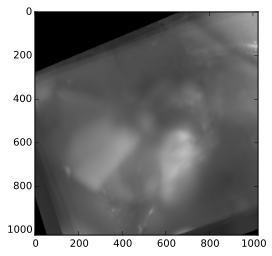

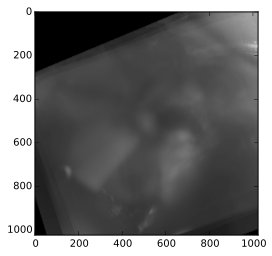

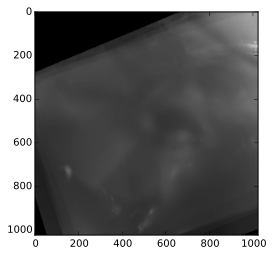

In [103]:
fimgs = np.array(swarm_imgs['df_f_psd'])
for img in np.mean(fimgs,axis = 0)[:3]:
    figure()
    #img = np.mean(fimgs,axis = 0)[0]
    #img = (img>0)*(-2*pi+img) + (img<0)*(img)
    #img = (img < pi)*img + (img > pi)*(mod(img,pi)*-1)
    imshow(img**0.2,cmap = cm.gray)

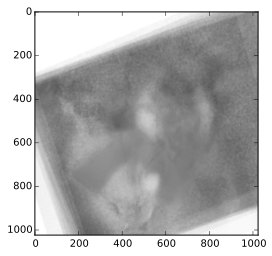

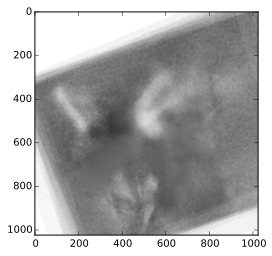

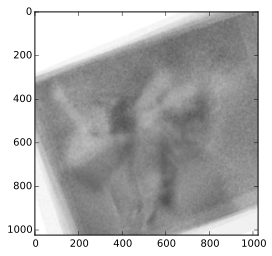

In [96]:
fimgs = np.array(swarm_imgs['csd_phase'])
for img in np.mean(fimgs,axis = 0)[:3]:
    figure()
    #img = np.mean(fimgs,axis = 0)[0]
    #img = (img>0)*(-2*pi+img) + (img<0)*(img)
    #img = (img < pi)*img + (img > pi)*(mod(img,pi)*-1)
    imshow(img,cmap = cm.gray,vmin = -2*pi,vmax = 0)

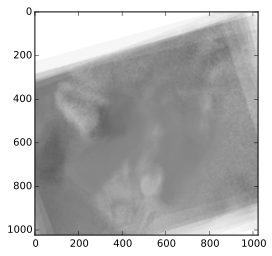

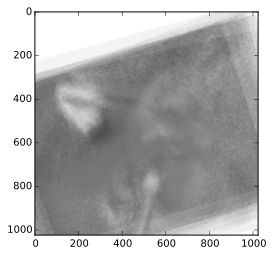

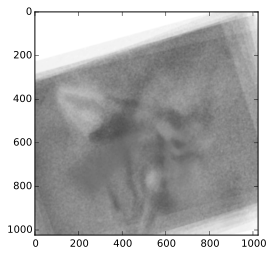

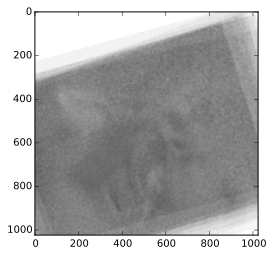

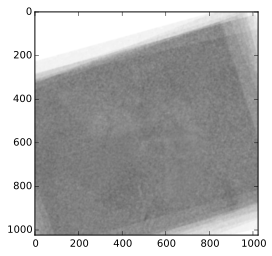

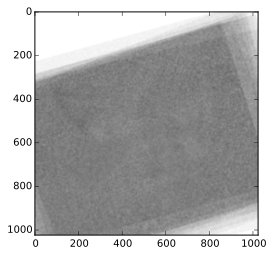

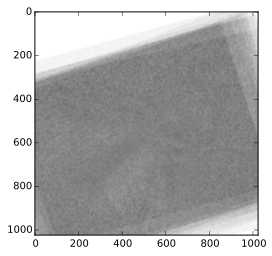

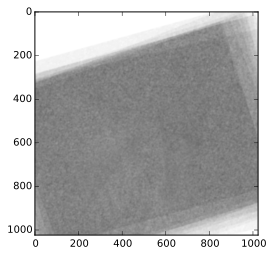

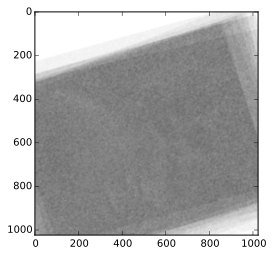

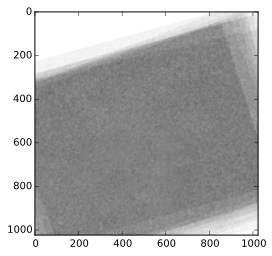

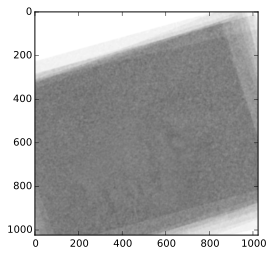

In [74]:
for img in np.mean(fimgs,axis = 0):
    figure()
    #img = np.mean(fimgs,axis = 0)[0]
    #img = (img>0)*(-2*pi+img) + (img<0)*(img)
    #img = (img < pi)*img + (img > pi)*(mod(img,pi)*-1)
    imshow(img,cmap = cm.gray,vmin = -2*pi,vmax = 0)

(array([  92233.,   15435.,       0.,       0.,       0.,       0.,
              0.,   21860.,  361718.,  557330.]),
 array([-6.28318223, -5.65486401, -5.02654578, -4.39822756, -3.76990934,
        -3.14159111, -2.51327289, -1.88495467, -1.25663645, -0.62831822,  0.        ]),
 <a list of 10 Patch objects>)

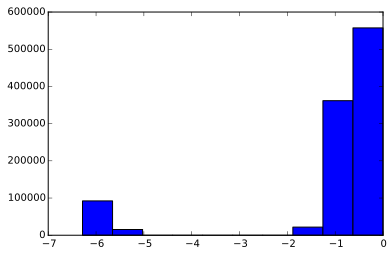

In [65]:
hist(img.ravel())

-2.8831853071795863

In [34]:
(mod(x,pi) < pi)

True